In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 458.3 MB 12 kB/s 


In [ ]:
!nvidia-smi

Tue Jul 13 10:09:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade grpcio >> /dev/null

ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.1 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.38.1 which is incompatible.


In [ ]:
!pip install --upgrade grpcio==1.32.0 >> /dev/null

ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow-gpu 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.


In [ ]:
!pip install tqdm
!pip install bert-for-tf2

     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=64587eebe4ee8f3d032472a4741b130b65dedcf89a0ba0cda3fd57624da0419f
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=2aaf807c5df586e1b6a8296d31793fab703877f120bee9984c4059c2f97df3ca
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=fd34229cdd298bd3c063ffa5cfdb654b8243d25a905484917458906b66c6dd1d
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 8.3MB/s 


In [ ]:

!pip install scikit-learn

In [ ]:
import os
import math

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig,map_stock_config_to_params,load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc


from sklearn.metrics import confusion_matrix , classification_report

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
sns.set(style="whitegrid",palette="muted",font_scale=1.2)
HAPPY_COLORS_PALLETE =["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALLETE))

rcParams["figure.figsize"]=12,8

RANDOM_SEED=42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [ ]:
train = pd.read_csv("drive/MyDrive/data/dataset.csv",names=["article","group"])


In [ ]:
for v,x in enumerate(train['article']):
    train['article'][v]=x.replace('\n','')

In [ ]:
train = train.append(valid).reset_index(drop=True)

In [ ]:
print(train.head())

                                            sentence  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [ ]:
print(train.shape)

(18000, 2)


In [ ]:
print(train.emotion)

0        sadness
1        sadness
2          anger
3           love
4          anger
          ...   
17995    sadness
17996        joy
17997        joy
17998        joy
17999        joy
Name: emotion, Length: 18000, dtype: object


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'number of examples per intent')

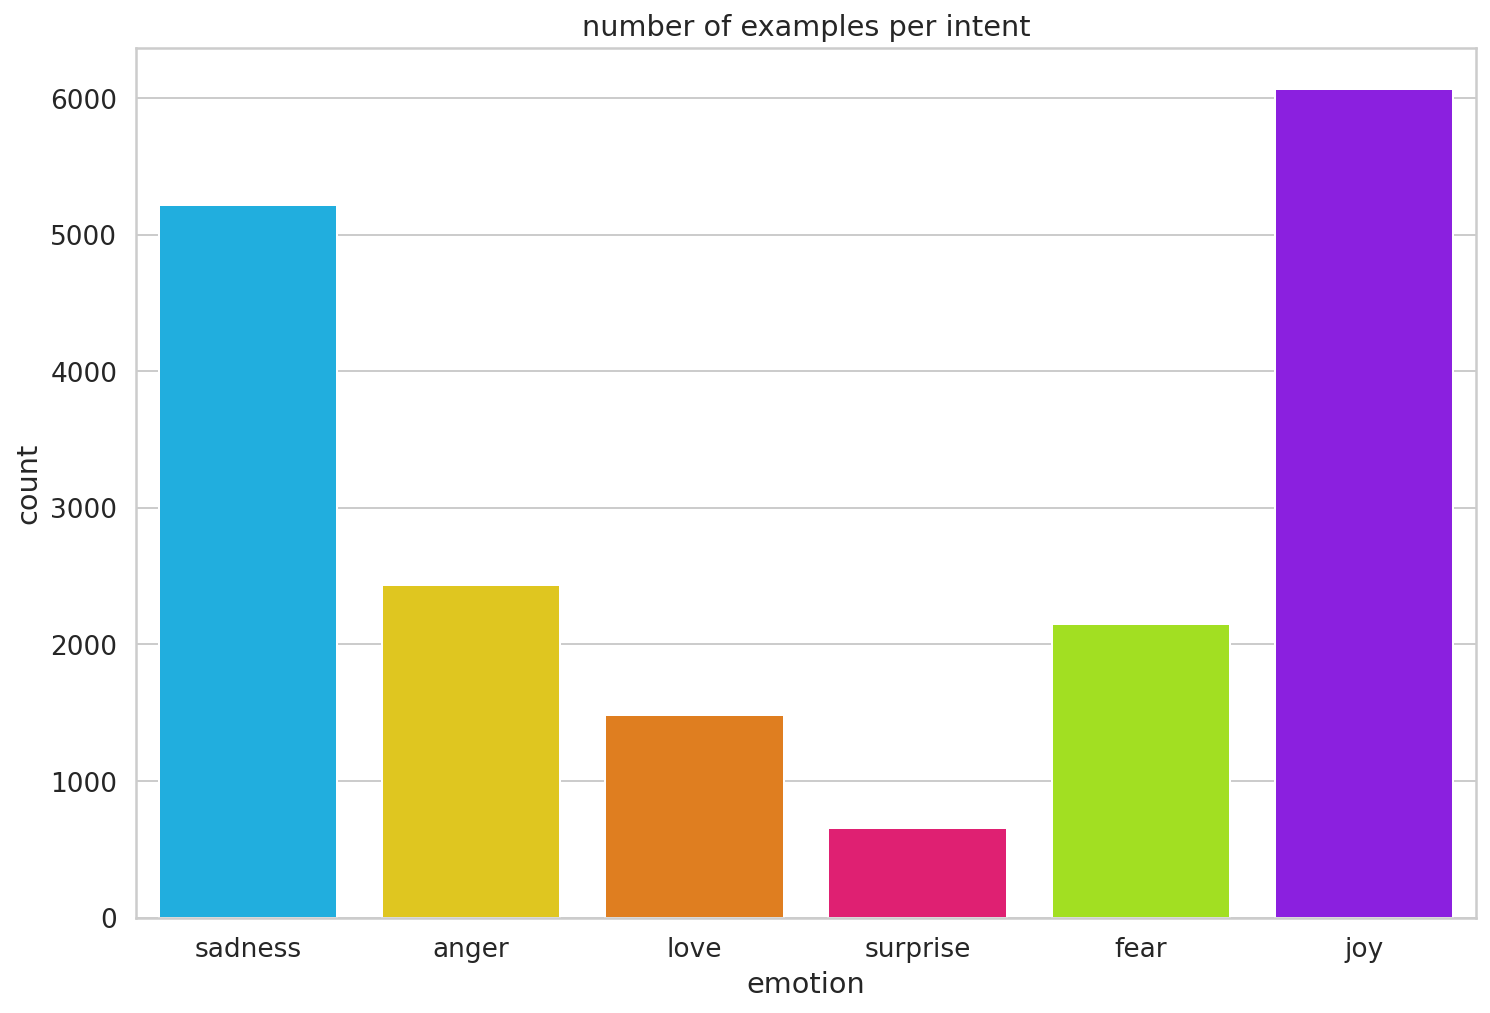

In [ ]:
chart = sns.countplot(train.emotion,palette=HAPPY_COLORS_PALLETE)
plt.title("number of examples per intent")

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip


--2021-03-14 12:32:55--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   152MB/s    in 2.6s    

2021-03-14 12:32:58 (152 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
!ls


drive  sample_data  uncased_L-12_H-768_A-12  uncased_L-12_H-768_A-12.zip


In [ ]:
os.makedirs('model',exist_ok=True)

In [ ]:
! mv uncased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name = 'uncased_L-12_H-768_A-12'
!ls

drive  model  sample_data  uncased_L-12_H-768_A-12.zip


In [ ]:
bert_ckpt_dir = os.path.join("model",bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir,"bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir,"bert_config.json")



In [ ]:
class EmotionClassification:

  DATA_COLUMN="sentence"
  LABEL_COLUMN="emotion"


  def __init__(self,train,test,tokenizer:FullTokenizer,classes,max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.train_x,self.train_y),(self.test_x,self.test_y))=map(self.prepare,[train,test])

    self.max_seq_len= min(max_seq_len,self.max_seq_len)

    self.train_x,self.test_x = map(self.pad,[self.train_x,self.test_x])

  def prepare(self,df):
    x,y=[],[]

    for _,row in tqdm(df.iterrows()):
      text,label = row[EmotionClassification.DATA_COLUMN],row[EmotionClassification.LABEL_COLUMN]

      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"]+tokens+["[SEP]"]
        
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)

      self.max_seq_len= max(self.max_seq_len,len(token_ids))

      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x),np.array(y)


  def pad(self,ids):
    x=[]

    for input_ids in ids:
      cut_point = min(len(input_ids),self.max_seq_len-2)
      input_ids = input_ids[:cut_point]
      input_ids = input_ids + [0]*(self.max_seq_len-len(input_ids))
      x.append(input_ids)

    return np.array(x)




In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir,"vocab.txt"))

In [ ]:
def create_model(max_seq_len,bert_config_file,bert_ckpt_file):
  with tf.io.gfile.GFile(bert_config_file,"r") as reader:
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params=map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params,name="bert")


    input_ids = keras.layers.Input(shape=(max_seq_len,),dtype="int32",name="input_ids")
    bert_output = bert(input_ids)

    print("bert_output",bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
        
    return model


In [ ]:
classes = train.emotion.unique().tolist()
data = EmotionClassification(train,test,tokenizer,classes,max_seq_len=128)

18000it [00:09, 1961.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
2000it [00:01, 1976.96it/s]


In [ ]:
model = create_model(data.max_seq_len,bert_config_file,bert_ckpt_file)

bert_output (None, 87, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f0e4025b1d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 87)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 87, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 4614  

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
import datetime
log_dir = "log/emotion_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
1013/1013 [==============================] - 840s 809ms/step - loss: 1.3759 - acc: 0.4675 - val_loss: 0.2720 - val_acc: 0.9094
Epoch 2/5
1013/1013 [==============================] - 806s 796ms/step - loss: 0.2433 - acc: 0.9171 - val_loss: 0.1870 - val_acc: 0.9272
Epoch 3/5
1013/1013 [==============================] - 815s 804ms/step - loss: 0.1666 - acc: 0.9371 - val_loss: 0.1800 - val_acc: 0.9350
Epoch 4/5
1013/1013 [==============================] - 814s 803ms/step - loss: 0.1216 - acc: 0.9521 - val_loss: 0.1719 - val_acc: 0.9344
Epoch 5/5
1013/1013 [==============================] - 818s 807ms/step - loss: 0.1018 - acc: 0.9566 - val_loss: 0.1809 - val_acc: 0.9322


In [ ]:
model.save_weights("drive/MyDrive/data/weights")

In [ ]:
model.evaluate(data.test_x,data.test_y)

56/63 [=========================>....] - ETA: 2s - loss: 0.2038 - acc: 0.9185